# Welcome to the GROMACS exercise for evaluating thermal conductivity of carbon nanotubes via NEMD method

Here follows the instructions for running a GROMACS simulation to compute thermal conductivity of single-wall carbon nanotubes. Provided by the Multi-Scale Modeling Lab of Politecnico di Torino (Italy).  These resources are intended for pedagogical purposes, and were designed for the undergraduate course: "Energy Applications of Materials", taught at Politecnico di Torino during spring 2026.
 
Matteo Fasano (matteo.fasano@polito.it)

Michele Pellegrino (michele.pellegrino@polito.it)

All rights reserved (2026)

In [57]:
import nglview as ng
import numpy as np
import matplotlib.pyplot as plt
import os

You can check if you correctly moved to the tutorial directory by the command:

In [2]:
!pwd

/home/michele/PhdCourse01WAZIV/cnt


You can also check the content of the directory

In [3]:
!ls

0-INPUT  2-TE  CNT53_12x057.gro  _POST-PROCESSING
1-EM	 3-NE  cnt.ipynb	 README-LAB-MD.txt


In [4]:
# Run this cell only once!
workdir = os.getcwd()
print("Work directory:",workdir)

Work directory: /home/michele/PhdCourse01WAZIV/cnt


## 1 - Setup preparation

First of all, what you need is a geometry file (file formats: `*.pdb`),  where all atom coordinates are indicated in the form of Cartesian coordinates.  In the `*.pdb` files also connections among atoms may be specified.  Readily available geometry generators can be found at: http://turin.nss.udel.edu/research/tubegenonline.html, or http://www.ugr.es/~gmdm/contub.htm.

We need first to convert the `*.pdb` geometry file (general and adopted also by many other software for MD) into `*.gro` (typical geometry file used by GROMACS). The following command can be used, where a **periodic computational box** of 16 nm x 16 nm x 16 nm is created, with the box edge (16 nm) being roughly 1.3 times the CNT length (periodicity is imposed along x, y and z): 

In [5]:
!gmx editconf -f 0-INPUT/CNT53_12x057.pdb -o CNT53_12x057.gro -box 16 16 16

               :-) GROMACS - gmx editconf, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx editconf -f 0-INPUT/CNT53_12x057.pdb -o CNT53_12x057.gro -box 16 16 16

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 784 atoms
No velocities found
    system size :  0.553  0.552 11.927 (nm)
    center      : -0.000 -0.000 -0.010 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  8.000  8.000  8.010 (nm)
new center      :  8.000  8.000  8.000 (nm)
new box vectors : 16.000 16.000 16.000 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :4096.00               (nm^3)

Back Off! I just backed up CNT53_12x057.gro to ./#CNT53_12x057.gro.1#

GROMACS remind

Next a topology (`*.top`) file needs to be created from the geometry file (`*.gro`). Topology files are basically a list of all the stretching, angular and dihedral bonds. In order to generate a `*.top` file from the corresponding `*.gro` file, the force-field files are requested. In particular, for this step the two required files are: `ffoplsaaCNT.n2t` and `ffoplsaaCNT.rtp` are used (included in the `ffoplsaaCNT.ff` subfolder).

Enter into the 0-INPUT folder:

In [6]:
%cd {workdir}/0-INPUT

/home/michele/PhdCourse01WAZIV/cnt/0-INPUT


and then run the `x2top` command:

In [7]:
!gmx x2top -f ../CNT53_12x057.gro -o CNT53_12x057.top -ff ffoplsaaCNT -noparam

                :-) GROMACS - gmx x2top, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt/0-INPUT
Command line:
  gmx x2top -f ../CNT53_12x057.gro -o CNT53_12x057.top -ff ffoplsaaCNT -noparam

Opening force field file ./ffoplsaaCNT.ff/ffoplsaaCNT.n2t
There are 3 name to type translations in file ./ffoplsaaCNT.ff

Generating bonds from distances...

There are 3 different atom types in your sample

Generating angles and dihedrals from bonds...
Before cleaning: 4610 pairs
Before cleaning: 4610 dihedrals

There are 1165 proper dihedrals,    0 impropers, 2318 angles
          3461 pairs,     1167 bonds and   784 atoms

Total charge is 0, total mass is 9416.67

Back Off! I just backed up CNT53_12x057.top to ./#CNT53_12x057.top.1#

Topologies generated by gmx x2top can not be trusted at face value. Please verify atomtypes and charges by comparison 

Check the content of the created topology file:

In [8]:
!cat CNT53_12x057.top

;
;	File 'CNT53_12x057.top' was generated
;	By user: michele (1001)
;	On host: denerg33012
;	At date: Fri Feb  6 12:07:24 2026
;
;	This is a include topology file
;
;	Created by:
;	               :-) GROMACS - gmx x2top, 2025.4-conda_forge (-:
;	
;	Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
;	Data prefix:  /home/michele/mambaforge/envs/inmod-md
;	Working dir:  /home/michele/PhdCourse01WAZIV/cnt/0-INPUT
;	Command line:
;	  gmx x2top -f ../CNT53_12x057.gro -o CNT53_12x057.top -ff ffoplsaaCNT -noparam
;	Force field was read from current directory or a relative path - path added.
;

; Include forcefield parameters
#include "./ffoplsaaCNT.ff/forcefield.itp"

[ moleculetype ]
; Name            nrexcl
ICE                 3

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
     1         C1      1    UNK      C      1          0     12.011
     2         C3      1    UNK      C      2          0     12.011
   

Finally, let us go back to the main folder:

In [9]:
%cd {workdir}

/home/michele/PhdCourse01WAZIV/cnt


## 2 - Energy minimization

Once the correct `*.top` file is available, we are ready to perform MD simulations. Before starting, the energy minimization of the simulated structure needs to be performed. In this case it is not strictly required, because our CNT is already in the configuration of minimal energy. However, in general, energy minimization is always necessary for a correct numerical convergence of the subsequent steps. Here, we need an `*.mdp` file where prescriptions on the numerical simulations are indicated (an `*.mdp` file is already included in the subfolder 1-EM). First, we pre-compile di simulation:

In [10]:
!gmx grompp -f 1-EM/em.mdp -c CNT53_12x057.gro -p ./0-INPUT/CNT53_12x057.top -o 1-EM/CNT53_12x057_em.tpr -po 1-EM/mdout.mdp

                :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx grompp -f 1-EM/em.mdp -c CNT53_12x057.gro -p ./0-INPUT/CNT53_12x057.top -o 1-EM/CNT53_12x057_em.tpr -po 1-EM/mdout.mdp

Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to -1619263521

Generated 0 of the 6 non-bonded parameter combinations

Excluding 3 bonded neighbours molecule type 'ICE'
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Number of degrees of freedom in T-Coupling group rest is 2349.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

This run will generate roughly 0 Mb of data

GROMACS reminds you: "This is where we have been working hard to push down per

then, we run it:

In [11]:
!gmx mdrun -s 1-EM/CNT53_12x057_em.tpr -o 1-EM/CNT53_12x057_em.trr -c CNT53_12x057_em.gro -g 1-EM/em.log -e 1-EM/em.edr -v

                :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx mdrun -s 1-EM/CNT53_12x057_em.tpr -o 1-EM/CNT53_12x057_em.trr -c CNT53_12x057_em.gro -g 1-EM/em.log -e 1-EM/em.edr -v

Compiled SIMD is AVX2_256, but CPU also supports AVX_512 (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file 1-EM/CNT53_12x057_em.tpr, VERSION 2025.4-conda_forge (single precision)

NOTE: Parallelization is limited by the small number of atoms,
      only starting 8 thread-MPI ranks.
      You can use the -nt and/or -ntmpi option to optimize the number of threads.


Using 8 MPI 

Since Gromacs discontinued the basic visualization tool `gmx view`, we are going to use a `nglview` widget instead:

In [26]:
# TODO, probably requires either pytraj or mdanalysis...

However, a much better visualization (of many geometry files such as: `*.pdb`, `*.gro`, `*.xyz`, etc., as well as of trajectories: `*.trr`) can be obtained by VMD, VEGA-ZZ (http://www.vegazz.net/) or OVITO (https://www.ovito.org/). For downloading them, you just need to make a registration. `*.pdb` files can be visualized also by `molviewer` readily available in MATLAB.

In [27]:
# E.g. if you have VMD installed in your environment:
!vmd 1-EM/CNT53_12x057_em.trr CNT53_12x057_em.gro

/usr/local/lib/vmd/vmd_LINUXAMD64: /lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /usr/local/lib/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 112 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA KNL:AVX-512F+CD+ER+PF 
Info) Free system memory: 114GB (91%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] NVIDIA RTX A4000   48 SM_8.6 @ 1.56 GHz, 16GB RAM, KTO, AE2, ZCP
Warning) Detected X11 'Composite' extension: if i

## 3 - Thermal equilibration

Here, we want to thermalize the whole system by attaching a Stochastic Velocity Rescale thermostat to the CNT. Therefore, we need an `*.mdp` file where prescriptions on the numerical simulations are indicated. An `*.mdp` file is already included in the subfolder 2-TE, let's have a look:

In [31]:
!cat 2-TE/*.mdp

;
;	File '2-TE/mdout.mdp' was generated
;	By user: michele (1001)
;	On host: denerg33012
;	At date: Fri Feb  6 12:29:06 2026
;
;	Created by:
;	               :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:
;	
;	Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
;	Data prefix:  /home/michele/mambaforge/envs/inmod-md
;	Working dir:  /home/michele/PhdCourse01WAZIV/cnt
;	Command line:
;	  gmx grompp -f 2-TE/md-te.mdp -c CNT53_12x057_em.gro -p ./0-INPUT/CNT53_12x057.top -t 1-EM/CNT53_12x057_em.trr -o 2-TE/CNT53_12x057_md-te.tpr -po 2-TE/mdout.mdp

; VARIOUS PREPROCESSING OPTIONS
; Preprocessor information: use cpp syntax.
; e.g.: -I/home/joe/doe -I/home/mary/roe
include                  = 
; e.g.: -DPOSRES -DFLEXIBLE (note these variable names are case sensitive)
define                   = 

; RUN CONTROL PARAMETERS
integrator               = md
; Start time and timestep in ps
tinit                    = 0
dt                       = 0.001
nsteps                   = 10000


The command `grompp` performs a preparation step before running the real md simulation and it produces a `*.tpr` file. In order to start the simulation from a previous minimal energy state (Energy minimization), use here the flag `-t` as follows:

In [32]:
!gmx grompp -f 2-TE/md-te.mdp -c CNT53_12x057_em.gro -p ./0-INPUT/CNT53_12x057.top -t 1-EM/CNT53_12x057_em.trr -o 2-TE/CNT53_12x057_md-te.tpr -po 2-TE/mdout.mdp

                :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx grompp -f 2-TE/md-te.mdp -c CNT53_12x057_em.gro -p ./0-INPUT/CNT53_12x057.top -t 1-EM/CNT53_12x057_em.trr -o 2-TE/CNT53_12x057_md-te.tpr -po 2-TE/mdout.mdp

Ignoring obsolete mdp entry 'gb_algorithm'
Ignoring obsolete mdp entry 'nstgbradii'
Ignoring obsolete mdp entry 'rgbradii'
Ignoring obsolete mdp entry 'gb_saltconc'
Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to -12667033

Generated 0 of the 6 non-bonded parameter combinations

Excluding 3 bonded neighbours molecule type 'ICE'

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Number of degrees of free

The real md simulation is performed by the command `mdrun`, which accepts the `*.tpr` as an input and it produces a `*.trr` file as an output, as follows:

In [33]:
!gmx mdrun -s 2-TE/CNT53_12x057_md-te.tpr -o 2-TE/CNT53_12x057_md-te.trr -c CNT53_12x057_md-te.gro -g 2-TE/md-te.log -e 2-TE/md-te.edr -v 

                :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx mdrun -s 2-TE/CNT53_12x057_md-te.tpr -o 2-TE/CNT53_12x057_md-te.trr -c CNT53_12x057_md-te.gro -g 2-TE/md-te.log -e 2-TE/md-te.edr -v

Compiled SIMD is AVX2_256, but CPU also supports AVX_512 (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file 2-TE/CNT53_12x057_md-te.tpr, VERSION 2025.4-conda_forge (single precision)

NOTE: Parallelization is limited by the small number of atoms,
      only starting 8 thread-MPI ranks.
      You can use the -nt and/or -ntmpi option to optimize the number of threa

**Tip** - if you want to restart the simulation, but run a different number of steps, there's no need to recompile, just use the `-nsteps` flag:
    
    !gmx mdrun -s 2-TE/CNT53_12x057_md-te.tpr ... -v -nsteps <possibly-different-number-of-steps>
    
So you can run a longer or a shorter simulation, depending on how powerful your laptop is.

After that the simulation is finished, we can extract the temperature/energy of the system from the trajectory using `gmx energy`. Since we are not using an interactive shell, the desired observable (`Temperature` in this case) is ging to be passed to the function using `echo`:

In [51]:
!echo Temperature | gmx energy -f 2-TE/md-te.edr -o 2-TE/energies.xvg

                :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx energy -f 2-TE/md-te.edr -o 2-TE/energies.xvg

Opened 2-TE/md-te.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Disper.-corr.    8  Coulomb-(SR)  
  9  Potential       10  Kinetic-En.     11  Total-Energy    12  Conserved-En. 
 13  Temperature     14  Pres.-DC        15  Pressure        16  Vir-XX        
 17  Vir-XY          18  Vir-XZ          19  Vir-YX          20  Vir-YY        
 2

For plotting temperature/energy history one can directly use `xmgrace`, if installed:

In [52]:
# If you have installed xmgrace:
!xmgrace -free -nxy 2-TE/energies.xvg

Otherwise `.xvg` can be read and plotted using a combination of `numpy` and `matplotlib`:

Text(0, 0.5, 'temperature [K]')

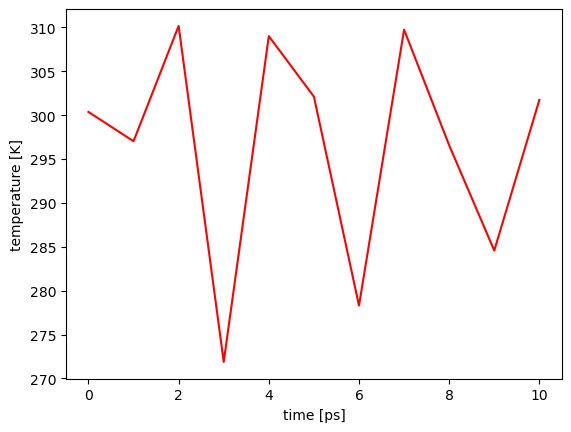

In [61]:
temperature = np.loadtxt("2-TE/energies.xvg", comments=("@", "#"))
fig1, ax1 = plt.subplots()
plt.plot(temperature[:,0],temperature[:,1],'r-')
plt.xlabel('time [ps]')
plt.ylabel('temperature [K]')

Again, the simulated trajectory can be opened with `nglview`:

In [38]:
# TODO

## 3 - Non-equilibirum simulation (NEMD)

Here, for computing the thermal conductivity of the carbon nanotube we perform a non-equilibrium computation, where the one end of the tube is attached to a Nose-Hoover (NH) thermostat at 320 K, the other end is attached to a NH thermostat at 280 K. Thermal conductivity is then computed by measuring both the slope of the temperature profile and the heat flux. 

For this computation, we need to subdivide all carbon atoms into several groups: this is done by creating an index file `*.ndx` (here, you can find it in the subfolder `0-INPUT`). However, a MATLAB subroutine (`makeindex.m`) is included in the subfolder `_POST-PROCESSING/MATLAB_VERSION` for making your own groups (instructions are therein included). As above, we need an `*.mdp` file where all prescriptions/inputs on the numerical simulations are provided (an `*.mdp` file is already included in the subfolder `3-NE`). Detailed instructions need to be given in the `*.mdp` file for specifying thermostats for each group of atoms. The provided MATLAB subroutine `makenosehoover.m` (included in the subfolder `_POST-PROCESSING/MATLAB_VERSION`) will enable  you to produce the proper text to be included in the `*.mdp` file before performing the `grompp` command.

In this case, we have already done this step and the provided `*.mdp` file is consistent:

In [65]:
!cat 3-NE/md-ne.mdp

; RUN CONTROL PARAMETERS
integrator               = md
; Start time and timestep in ps
tinit                    = 0
dt                       = 0.001
nsteps                   = 200000
; For exact run continuation or redoing part of a run
init_step                = 0
; mode for center of mass motion removal
comm-mode                = 
; number of steps for center of mass motion removal
nstcomm                  = 100
nstcalcenergy            = 100
; group(s) for center of mass motion removal
comm-grps                = 

; output control
nstxout                  = 100
nstvout                  = 100
nstfout                  = 100

; NEIGHBORSEARCHING PARAMETERS
; nblist update frequency
nstlist                  = 10
; ns algorithm (simple or grid)
ns_type                  = grid
; Periodic boundary conditions: xyz (default), no (vacuum)
; or full (infinite systems only)
pbc                      = xyz
; nblist cut-off        
rlist                    = 1
cutoff-scheme            = verlet
nhc

The command grompp performs a preparation step before running the real md simulation and it produces a `*.tpr` file. In order to start the simulation from a the previous equilibrium state (equilibration) use here the flag `-t`:

In [74]:
!gmx grompp -n 0-INPUT/CNT53-long.ndx -f 3-NE/md-ne.mdp -c CNT53_12x057_md-te.gro -t 2-TE/CNT53_12x057_md-te.trr -p ./0-INPUT/CNT53_12x057.top -o 3-NE/CNT53_12x057_md-ne.tpr -po 3-NE/mdout.mdp -maxwarn 1

                :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx grompp -n 0-INPUT/CNT53-long.ndx -f 3-NE/md-ne.mdp -c CNT53_12x057_md-te.gro -t 2-TE/CNT53_12x057_md-te.trr -p ./0-INPUT/CNT53_12x057.top -o 3-NE/CNT53_12x057_md-ne.tpr -po 3-NE/mdout.mdp -maxwarn 1

Ignoring obsolete mdp entry 'gb_algorithm'
Ignoring obsolete mdp entry 'nstgbradii'
Ignoring obsolete mdp entry 'rgbradii'
Ignoring obsolete mdp entry 'gb_saltconc'
Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to 2091120127

Generated 0 of the 6 non-bonded parameter combinations

Excluding 3 bonded neighbours molecule type 'ICE'

Taking velocities from 'CNT53_12x057_md-te.gro'
Number of degrees of freedom in T-Coupling group INT1 is 44.94
Number of degrees of freedom in T-Coupling group INT2 is 44.94
Number of degree

**Tip** - try to remove the `-maxwarn 1` flag and see what happens: Gromacs will throw a warning since some temperature coupling groups do not use temperature coupling. This is perfectly ok in our case, since we are doing NEMD, but mind that in general Gromacs will throw warning in **many** occasions. So always read warnings and decide if they are innocuous or not!

The real md simulation is performed by the command mdrun, which accepts the `*.tpr` as an input and it produces a `*.trr` file as an output, as follows:

In [75]:
!gmx mdrun -s 3-NE/CNT53_12x057_md-ne.tpr -o 3-NE/CNT53_12x057_md-ne.trr -c CNT53_12x057_md-ne.gro -g 3-NE/md-ne.log -e 3-NE/md-ne.edr

                :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx mdrun -s 3-NE/CNT53_12x057_md-ne.tpr -o 3-NE/CNT53_12x057_md-ne.trr -c CNT53_12x057_md-ne.gro -g 3-NE/md-ne.log -e 3-NE/md-ne.edr


Back Off! I just backed up 3-NE/md-ne.log to 3-NE/#md-ne.log.2#
Compiled SIMD is AVX2_256, but CPU also supports AVX_512 (see log).
The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file 3-NE/CNT53_12x057_md-ne.tpr, VERSION 2025.4-conda_forge (single precision)

NOTE: Parallelization is limited by the small number of atoms,
      only starting 8 thread-MPI ranks.
      You can us

The run progess is shown in the `*.log` file:

In [72]:
!cat 3-NE/*log

                :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Copyright 1991-2025 The GROMACS Authors.
GROMACS is free software; you can redistribute it and/or modify it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either version 2.1
of the License, or (at your option) any later version.

                         Current GROMACS contributors:
       Mark Abraham           Andrey Alekseenko           Brian Andrews       
      Vladimir Basov              Paul Bauer                Hugh Bird         
      Eliane Briand               Ania Brown              Mahesh Doijade      
      Giacomo Fiorin          Stefan Fleischmann          Sergey Gorelov      
   Gilles Gouaillardet            Alan Gray              M. Eric Irrgang      
   Farzaneh Jalalypour         Petter Johansson          Carsten Kutzner      
    Grzegorz Łazarski         Justin A. Lemkul          Magnus Lundborg      
       Pascal Merz             Vedran Mile

Checking the `*.log` file may be useful when running a simulation on the background or in a queue.

**Tip** - At the end of the `*.log` file, GROMACS reports statistics on computational efficiency. You can get an estimate of how fast is the simulation (ns/day and real-hour/ns) and which activities are consuming the most time. This information is very useful if you are running becnhmarks or just trying to make your simulation more efficient.

For extracting the temperature/energy history use `gmx energy` and then type the numbers corresponding to the quantities to extract, as suggested by the interactive menu. In this case type from 35 to 86 (and we provide them by `echo` command), in order to analyze the trend of temperature in the different groups of carbon atoms of the nanotube at steady state conditions, namely after 50 ps:

In [76]:
!echo "35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 0" | gmx energy -f 3-NE/md-ne.edr -o _POST-PROCESSING/Temp.xvg -b 50 -e 200

                :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx energy -f 3-NE/md-ne.edr -o _POST-PROCESSING/Temp.xvg -b 50 -e 200

Opened 3-NE/md-ne.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Disper.-corr.    8  Coulomb-(SR)  
  9  Potential       10  Kinetic-En.     11  Total-Energy    12  Conserved-En. 
 13  Temperature     14  Pres.-DC        15  Pressure        16  Vir-XX        
 17  Vir-XY          18  Vir-XZ          19  Vir-YX          

In [77]:
!cat _POST-PROCESSING/Temp.xvg

# This file was created Fri Feb  6 13:15:05 2026
# Created by:
#                :-) GROMACS - gmx energy, 2025.4-conda_forge (-:
# 
# Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
# Data prefix:  /home/michele/mambaforge/envs/inmod-md
# Working dir:  /home/michele/PhdCourse01WAZIV/cnt
# Command line:
#   gmx energy -f 3-NE/md-ne.edr -o _POST-PROCESSING/Temp.xvg -b 50 -e 200
# gmx energy is part of G R O M A C S:
#
# Great Red Owns Many ACres of Sand 
#
@    title "GROMACS Energies"
@    xaxis  label "Time (ps)"
@    yaxis  label "(K)"
@TYPE xy
@ view 0.15, 0.15, 0.75, 0.85
@ legend on
@ legend box on
@ legend loctype view
@ legend 0.78, 0.8
@ legend length 2
@ s0 legend "T-INT1"
@ s1 legend "T-INT2"
@ s2 legend "T-INT3"
@ s3 legend "T-INT4"
@ s4 legend "T-INT5"
@ s5 legend "T-INT6"
@ s6 legend "T-INT7"
@ s7 legend "T-INT8"
@ s8 legend "T-INT9"
@ s9 legend "T-INT10"
@ s10 legend "T-INT11"
@ s11 legend "T-INT12"
@ s12 legend "T-INT13"
@ s13 legend "T-INT14"
@ s14 

The heat flux through the nanotube can be computed as:

$q = f \cdot N_{DOF} \cdot k_B \cdot T_a / S$,

being:

$f$ : Nose-Hoover (NH) friction factor [s$^{-1}$]

$N_{DOF}$ : Number of degrees of freedom attached to NH [-]

$k_B$ : Boltzmann constant [J/K]

$T_a$ : Average temperature of NH [K]

$S$ : Tube cross-section surface [m$^2$]

See the slides for a more comprehensive explanation. The average friction factor during the simulation at steady state conditions can be extracted as:

In [78]:
!echo "vXi-INT52" | gmx energy -f 3-NE/md-ne.edr -o _POST-PROCESSING/FrictionNH.xvg -b 50 -e 200

                :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /home/michele/mambaforge/envs/inmod-md/bin.AVX2_256/gmx
Data prefix:  /home/michele/mambaforge/envs/inmod-md
Working dir:  /home/michele/PhdCourse01WAZIV/cnt
Command line:
  gmx energy -f 3-NE/md-ne.edr -o _POST-PROCESSING/FrictionNH.xvg -b 50 -e 200

Opened 3-NE/md-ne.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Disper.-corr.    8  Coulomb-(SR)  
  9  Potential       10  Kinetic-En.     11  Total-Energy    12  Conserved-En. 
 13  Temperature     14  Pres.-DC        15  Pressure        16  Vir-XX        
 17  Vir-XY          18  Vir-XZ          19  Vir-YX    

Finally, the post-processing (computation of thermal conductivity) can be performed by the provided shell routine `compute-lambda.sh` included in the subfolder `_POST-PROCESSING`. The average value of friction factor of the NH thermostat (group `INT52`) should be then updated in this shell script. 

Just open it and then update the value of friction factor in the `xi` variable 
(0.592108e12, in this case):

    xi=$(echo "0.592108e12" | awk {'printf "%.30f", $1'})    # [s^-1]  Nose-Hoover (NH) Friction factor

After saving the file, it can be made as executable by:

In [81]:
!chmod 777 ./_POST-PROCESSING/compute-lambda.sh

and then run by:

In [83]:
# I am not able to run this from notebook...
!./_POST-PROCESSING/compute-lambda.sh

cat: write error: Broken pipe


Notice that a MATLAB version of the previous script is also available
in the _POST-PROCESSING folder.